In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
import constants as cst
from scipy.spatial.transform import Rotation
import json


In [ ]:
def asSpherical(xyz):
    x       = xyz[0]
    y       = xyz[1]
    z       = xyz[2]
    r       =  np.sqrt(x*x + y*y + z*z)
    theta   =  np.arccos(z/r)
    phi     =  np.arctan2(y,x)
    return [r,theta,phi]


J_to_eV = (1*u.J / (1*u.eV)).decompose()


def calculate_velocity(energy, mass):
    velocity = np.sqrt(1-(mass**2 * cst.c**4/energy**2)) * cst.c
    return velocity


def calculate_trajectory(b_field, energy, charge, l):
    position = np.array([0,0,0]) * u.m
    velocity_0 = calculate_velocity(energy, cst.e_mass).to_value()
    velocity = np.array([velocity_0, 0, 0]) * u.m / u.s
    R = ((energy/(cst.c*charge*b_field[2])).decompose())
    n = 100
    dt = (l/np.linalg.norm(velocity))/n
    x, y = [position[0].to_value()], [position[1].to_value()]
    v = np.linalg.norm(velocity)
    for i in range(n):
        velocity = u.Quantity([v * np.sin((v * dt * (i+1) / R).to(u.rad,equivalencies=u.dimensionless_angles())), 
                               v * np.cos((v * dt * (i+1) / R).to(u.rad,equivalencies=u.dimensionless_angles())), 
                               velocity[2]])
        position = u.Quantity([position[0] + velocity[1] * dt, 
                               position[1] + velocity[0] * dt, 
                               position[2]])
        x.append(position[0].to_value())
        y.append(position[1].to_value())
    return x, y


In [ ]:
class Particle:
    def __init__(self, mass, energy, charge, pos_start, velocity, crit_energy, travel_dist) -> None:
        self.mass = mass
        self.energy = energy
        self.charge = charge
        self.position_start = pos_start
        self.velocity = velocity
        self.position_end = None
        self.crit_energy = crit_energy
        self.distance_travel = travel_dist
        self.color = None
    def propagate(self):
        if self.position_end == None:
            r, theta, phi = asSpherical(self.velocity)
            pos = np.array([0, 0, 0]) * u.m
            pos[0] = self.position_start[0] + np.sin(theta) * np.cos(phi) * self.distance_travel
            pos[1] = self.position_start[1] + np.sin(theta) * np.sin(phi) * self.distance_travel
            pos[2] = self.position_start[2] + np.cos(theta) * self.distance_travel
            self.position_end = pos
        return self.position_end

    def divide(self):
        pass

class Electron(Particle):
    def __init__(self, energy, pos_start, velocity) -> None:
        super().__init__(cst.e_mass, energy, cst.e_charge, pos_start, velocity, cst.crit_energy_e,  8.9 * np.log(2) * u.mm)
        self.color = "blue"
    def divide(self):
        rotaxis = np.array([np.random.uniform(-1, 1), np.random.uniform(-1, 1), np.random.uniform(-1, 1)])
        rotaxis = rotaxis / np.linalg.norm(rotaxis)
        theta = np.pi/4
        rot1 = Rotation.from_rotvec(theta * rotaxis)
        rot2 = Rotation.from_rotvec(-theta * rotaxis)
        part1 = Electron(self.energy/2, self.position_end, rot1.apply(self.velocity))
        part2 = Photon(self.energy/2, self.position_end, rot2.apply(self.velocity))
        return [part1, part2]

class Positron(Particle):
    def __init__(self, energy, pos_start, velocity) -> None:
        super().__init__(cst.e_mass, energy, -cst.e_charge, pos_start, velocity, cst.crit_energy_e,  8.9 * np.log(2) * u.mm)
        self.color = "red"

    def divide(self):
        rotaxis = np.array([np.random.uniform(), np.random.uniform(), np.random.uniform()])
        rotaxis = rotaxis / np.linalg.norm(rotaxis)
        theta = np.pi/4
        rot1 = Rotation.from_rotvec(theta * rotaxis)
        rot2 = Rotation.from_rotvec(-theta * rotaxis)
        part1 = Positron(self.energy/2, self.position_end, rot1.apply(self.velocity))
        part2 = Photon(self.energy/2, self.position_end, rot2.apply(self.velocity))
        return [part1, part2]


class Photon(Particle):
    def __init__(self, energy, pos_start, velocity) -> None:
        super().__init__(0, energy, 0, pos_start, velocity, cst.crit_energy_p,  8.9 * 7 / 9 * u.mm)
        self.color = "yellow"
        
    def divide(self):
        rotaxis = np.array([np.random.uniform(), np.random.uniform(), np.random.uniform()])
        rotaxis = rotaxis / np.linalg.norm(rotaxis)
        theta = np.pi/4
        rot1 = Rotation.from_rotvec(theta * rotaxis)
        rot2 = Rotation.from_rotvec(-theta * rotaxis)
        part1 = Electron(self.energy/2, self.position_end, rot1.apply(self.velocity))
        part2 = Positron(self.energy/2, self.position_end, rot2.apply(self.velocity))
        return [part1, part2]
        



In [ ]:
table = pd.read_json("test.json")

In [ ]:
b_field = np.array([0, 0, 2])
angles = []
for particl in table.values:
    charge, energy, mass = particl
    x, y = calculate_trajectory(b_field* u.T, energy * u.GeV, charge * u.C, 1 * u.m)
    xl = x[-1]
    yl = y[-1]
    xp = x[-2]
    yp = y[-2]
    vx = xl - xp
    vy = yl - yp
    v = np.array([vx, vy])
    v = v/np.linalg.norm(v)
    angle = -np.arctan2(v[1], v[0])
    angles.append(angle)
table["angles"] = angles
table

In [ ]:
box_size = 5 * u.cm
particles = []
for particle in table.values:
    charge, energy, mass, angle = particle
    vel = calculate_velocity(energy * u.GeV, mass * u.kg)
    p1 = Electron(energy * u.GeV, np.array([0, 0, 0]) * u.m, vel * np.array([np.cos(angle), np.sin(angle), 0]))
    got_particles = [p1]
    while got_particles:
        current_particle = got_particles.pop(0)
        particles.append(current_particle)
        new_pos = current_particle.propagate()
        if current_particle.energy > current_particle.crit_energy * 2 and (0 * u.cm <= current_particle.position_end[0] <= box_size) and (-box_size <= (current_particle.position_end[1]) <= 0 * u.cm):
            new_particles = current_particle.divide()
            got_particles.extend(new_particles)
        

In [ ]:
plt.figure().add_subplot(projection='3d')
print(len(particles))
for p in particles:
    pst = p.position_start.value
    pend = p.position_end.value
    x = np.array([pst[0], pend[0]])
    y = np.array([pst[1], pend[1]])
    z = np.array([pst[2], pend[2]])
    plt.plot(x, y, z, color=p.color)

In [ ]:
mini_box_size = 1 * u.mm

N = int((box_size // mini_box_size).value)

energies = np.zeros((N, N, N)) * u.GeV
for p in particles:
    final_pos = p.position_end
    nx = int((final_pos[0]//mini_box_size).value)
    ny = -int((final_pos[1]//mini_box_size).value)
    nz = int((final_pos[2]//mini_box_size).value)
    if 0 < nx < N and 0<ny < N and 0 < nz < N:
        energies[nx, ny, nz] += p.energy

print(energies)
#plt.matshow(energies.value)

In [ ]:
energies2 = energies.value.tolist()
results = {
    "box_size": box_size.value,
    "mini_box_size" : mini_box_size.to(u.cm).value,
    "values" : energies2
}
# print(energies2[0, 0])
with open("results.json", "w") as r:
    json.dump(results, r)

[  1.     1.99   2.98   3.97   4.96   5.95   6.94   7.93   8.92   9.91
  10.9   11.89  12.88  13.87  14.86  15.85  16.84  17.83  18.82  19.81
  20.8   21.79  22.78  23.77  24.76  25.75  26.74  27.73  28.72  29.71
  30.7   31.69  32.68  33.67  34.66  35.65  36.64  37.63  38.62  39.61
  40.6   41.59  42.58  43.57  44.56  45.55  46.54  47.53  48.52  49.51
  50.5   51.49  52.48  53.47  54.46  55.45  56.44  57.43  58.42  59.41
  60.4   61.39  62.38  63.37  64.36  65.35  66.34  67.33  68.32  69.31
  70.3   71.29  72.28  73.27  74.26  75.25  76.24  77.23  78.22  79.21
  80.2   81.19  82.18  83.17  84.16  85.15  86.14  87.13  88.12  89.11
  90.1   91.09  92.08  93.07  94.06  95.05  96.04  97.03  98.02  99.01
 100.  ] GeV
[20.67888083 17.99829929 15.94155553 15.94155553 14.31135274 14.31135274
 14.31135274 14.31135274 14.31135274 12.98636085 12.98636085 12.98636085
 12.98636085 12.98636085 12.98636085 12.98636085 12.98636085 12.98636085
 12.98636085 11.88760577 11.88760577 11.88760577 11.887605

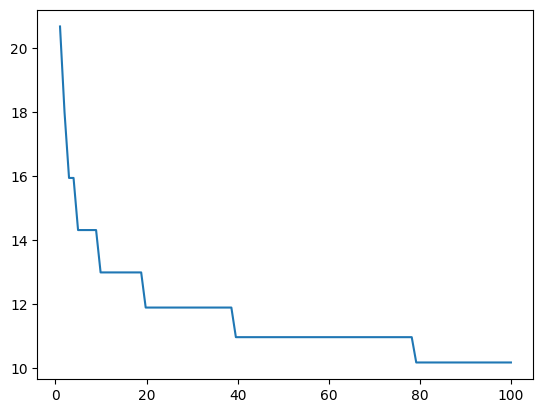

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import constants as cst
import astropy.units as u
distance_travel = 0.89*u.cm
def y(energy):
    return np.rad2deg(np.arcsin(cst.Rm/(np.ceil(np.log2(energy / cst.crit_energy_e)) * distance_travel)))
energies = np.linspace(1, 100, 101)*u.GeV
plt.plot(energies, y(energies))
print(energies)
print(y(energies))

In [ ]:
theta = np.arcsin(cst.Rm/(np.ceil(np.log2(self.energy / cst.crit_energy_e)) * self.distance_travel))
